In [1]:
!pip install adversarial-robustness-toolbox
!pip install git+https://github.com/nottombrown/imagenet_stubs
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.4 MB 25.9 MB/s 
     |████████████████████████████████| 25.3 MB 79 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-a6_c6u_p
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-a6_c6u_p
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794839 sha256=1ba9d411e51ccb6d3224d295eacba182013022c385422b8afae7f9eb47536f56
  Stored in directory: /tmp/pip-ephem-wheel-cache-1fjeffgf/wheels/33/0f/5a/c83688c23a05eb9e88527a8944da56dbe007c86f534b0c1dad
Successfully built imagenet-s

# ART - Adversarial Patch - TensorFlow v2

In [2]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

# Settings

In [3]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

# Model definition

In [4]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

102981632/102967424 [==============================] - 1s 0us/step


# Imagenet training images

In [5]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

In [6]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

# Adversarial patch generation

In [7]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name)
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

Adversarial Patch TensorFlow v2:   0%|          | 0/500 [00:00<?, ?it/s]

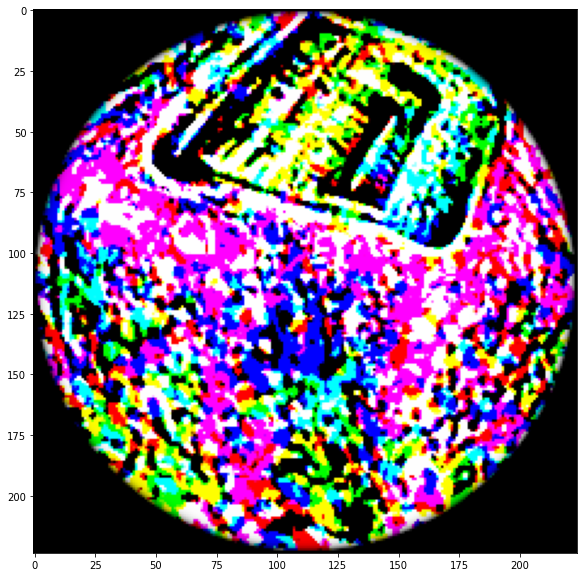

In [8]:
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

# Evaluation

In [9]:
patched_images = ap.apply_patch(images, scale=0.5)

In [10]:
def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

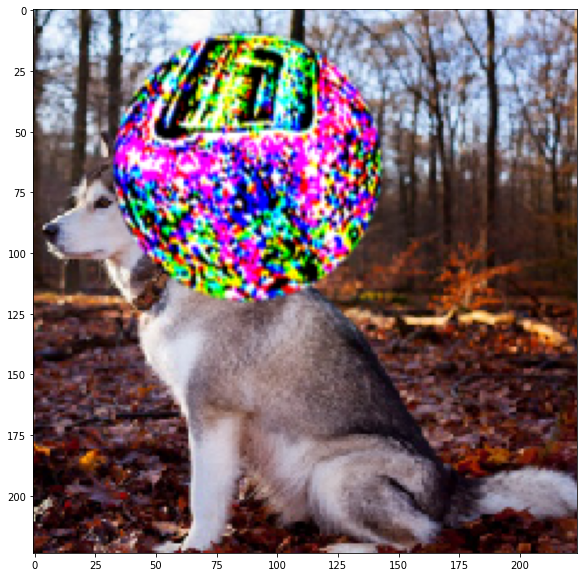

49152/35363 [=========================================] - 0s 0us/step
Predictions:
toaster            0.96
malamute           0.02
Eskimo_dog         0.00
shovel             0.00
Norwegian_elkhound 0.00


In [11]:
predict_model(tfc, patched_images[0])

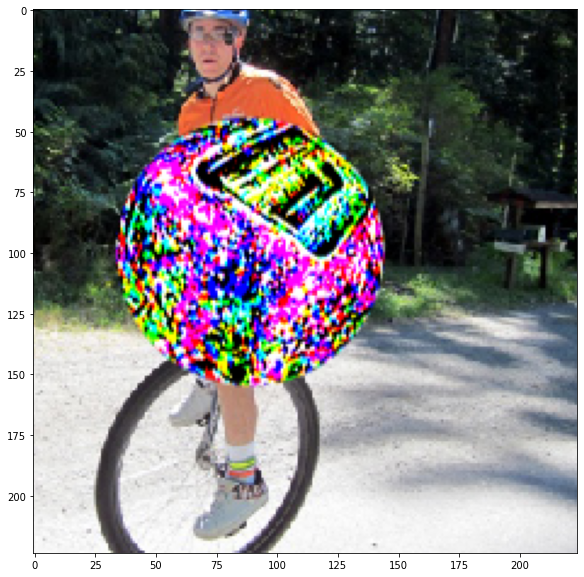

Predictions:
toaster       1.00
unicycle      0.00
crash_helmet  0.00
mountain_bike 0.00
poncho        0.00


In [12]:
predict_model(tfc, patched_images[1])

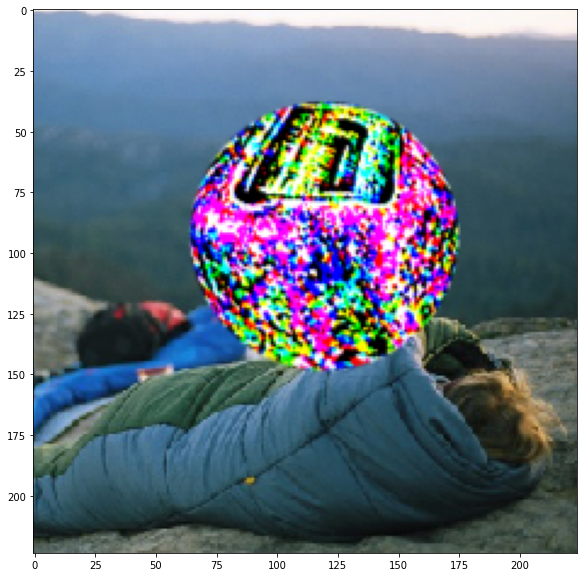

Predictions:
toaster      1.00
piggy_bank   0.00
crash_helmet 0.00
balloon      0.00
binoculars   0.00


In [13]:
predict_model(tfc, patched_images[2])